In [1]:
# Import libraries
import time as tm
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
%matplotlib inline

/Users/hsienhaohsu/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## PART 0: Preliminary treatment of the data set
### 0.1. Import data from 3 data files





In [6]:
start_time=tm.time()
url=('https://raw.githubusercontent.com/duonghung86/hello-world/master/COURIER.csv',
     'https://raw.githubusercontent.com/duonghung86/hello-world/master/CALIBRI.csv',
    'https://raw.githubusercontent.com/duonghung86/hello-world/master/TIMES.csv')
# creat an empty list of data frame
df={} # Data frame contain all data
nof=len(url) # number of input files
font_name=['COURIER','CALIBRI','TIMES']
for i in np.arange(nof):
  df[i] = pd.read_csv(url[i])
  #print('Display first 5 rows of data frame \n',df[i].head(5))

### 0.2. DISCARD the 9 columns listed below : fontVariant, m_label, orientation, m_top, m_left, originalH, originalW, h, w
* KEEP the 3 columns {font, strength, italic}
* KEEP the 400 columns named r0c0, r0c1,r0c2, ... , r19c18, r19c19

In [7]:
discard_columns=('fontVariant','m_label','orientation','m_top','m_left','originalH','originalW','h','w')
for j in np.arange(nof):
  for i in np.arange(len(discard_columns)):
    df[j]=df[j].drop(discard_columns[i],1)
  print('Display names of Data frame',font_name[j], 'after discarding \n',df[j].columns)

Display names of Data frame COURIER after discarding 
 Index(['font', 'strength', 'italic', 'r0c0', 'r0c1', 'r0c2', 'r0c3', 'r0c4',
       'r0c5', 'r0c6',
       ...
       'r19c10', 'r19c11', 'r19c12', 'r19c13', 'r19c14', 'r19c15', 'r19c16',
       'r19c17', 'r19c18', 'r19c19'],
      dtype='object', length=403)
Display names of Data frame CALIBRI after discarding 
 Index(['font', 'strength', 'italic', 'r0c0', 'r0c1', 'r0c2', 'r0c3', 'r0c4',
       'r0c5', 'r0c6',
       ...
       'r19c10', 'r19c11', 'r19c12', 'r19c13', 'r19c14', 'r19c15', 'r19c16',
       'r19c17', 'r19c18', 'r19c19'],
      dtype='object', length=403)
Display names of Data frame TIMES after discarding 
 Index(['font', 'strength', 'italic', 'r0c0', 'r0c1', 'r0c2', 'r0c3', 'r0c4',
       'r0c5', 'r0c6',
       ...
       'r19c10', 'r19c11', 'r19c12', 'r19c13', 'r19c14', 'r19c15', 'r19c16',
       'r19c17', 'r19c18', 'r19c19'],
      dtype='object', length=403)


### 0.3. Define then three CLASSES of images of "normal" characters as follows
* CL1 = all rows of COURIER.csv file for which {row # >1 and strength = 0.4 and italic=0}

* CL2 = all rows of CALIBRI.csv file for which {row # >1 and strength = 0.4 and italic=0}

* CL3 = all rows of TIME.csv file for which {row # >1 and strength = 0.4 and italic=0}
#### Display their respective sizes n1, n2, n3

In [8]:
cl={}   
N=0
for j in np.arange(nof):
  length_data=len(df[j])
  cl[j]=df[j][df[j].strength==0.4]
  cl[j]=cl[j][cl[j].italic==0]
  N+=len(cl[j])
  print('Size of CL',j+1,'is',len(cl[j])) 
  print('Display first 5 rows of CL',j+1,'\n',cl[j].head(5))
print('Size of full data set DATA is',N) 
  


Size of CL 1 is 4262
Display first 5 rows of CL 1 
       font  strength  italic  r0c0  r0c1  r0c2  r0c3  r0c4  r0c5  r0c6  \
0  COURIER       0.4       0     1     1     1     1     1     1     1   
1  COURIER       0.4       0     1     9    14    15    45    87   134   
2  COURIER       0.4       0     1     3    21    46    67   128   178   
3  COURIER       0.4       0     1     1     1     1     1     1     1   
4  COURIER       0.4       0   255   255   255   255   255   255   171   

    ...    r19c10  r19c11  r19c12  r19c13  r19c14  r19c15  r19c16  r19c17  \
0   ...         1       1       1       1       1       1       1       1   
1   ...       162     150     120      99      80      61      34      26   
2   ...       184     184     166     139     116      83      64      45   
3   ...         1       1       1       1       1       1       1       1   
4   ...         1       1       1       1       1     255     255     255   

   r19c18  r19c19  
0       1       1  


The full data set (denoted DATA ) for the next questions will be the union of the three classes CL1 , CL2, CL3 and hence has size N= n1 +n2 +n3

In [9]:
data=pd.concat([cl[0],cl[1],cl[2]])
data_df=data # Data frame of DATA
data=np.array(data.loc[:,'r0c0':'r19c19'].values)
#print('Display first 5 rows of DATA \n',data[:5,:])

end_time=tm.time()
print(' The computing time for the preliminary treatment part is ' , round (end_time-start_time,2), 'second')

 The computing time for the preliminary treatment part is  16.1 second




---


## PART 0
### 0.1. Compute the means m1 = mean(X1) ....mean(X400) = m400 and the standard deviations s1 = std(X1) ....s400 = std(X400)

In [10]:
start_time=tm.time()
nofe=data.shape[1] #Number of features
mean_f=np.empty(nofe) # array contains means of all features
std_f=np.empty(nofe) # array contains standard deviation of all features
for i in np.arange(nofe):
    mean_f[i]=np.mean(data[:,i])
    std_f[i]=np.std(data[:,i])
#print('Display first 5 values of the mean array \n',mean_f[:5])
#print('Display first 5 values of the standard deviation array \n',std_f[:5])

In [15]:
?plt.hist()

### 0.1.1. Display
* Histogram of the means m1 m2 ... m400




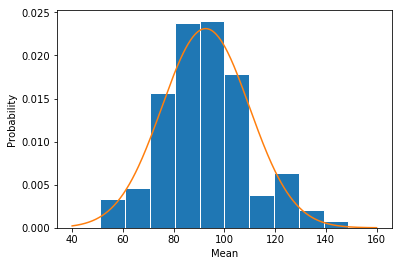

In [16]:
# Plot the histogram of the means
plt.hist(mean_f,edgecolor='white',normed=True)
#plt.title('Histogram of the 400 means')
plt.xlabel('Mean')
plt.ylabel('Probability')
# Plot the norm distribution 
#   Find minimum and maximum of xticks → Location of norm distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(mean_f))
m, s = stats.norm.fit(mean_f) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") 
plt.show()

**COMMENT**: Values of means spreads well from 40 to 160. Their distribution match the norm distrubution closely. Means in the range between 80 and 100 have the highest frequency

* Histogram of the standard deviations s1 s2 .... s400

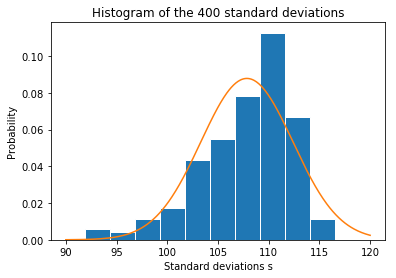

In [17]:
#Plot the histogram
plt.hist(std_f,edgecolor='white',normed=True)
plt.title("Histogram of the 400 standard deviations")
plt.xlabel('Standard deviations s')
plt.ylabel('Probability')
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(std_f))
# Plot the norm distribution 
#   Find minimum and maximum of xticks → Location of norm distribution
m, s = stats.norm.fit(std_f) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm")
plt.show() #std histogram

**COMMENT:** The values of 400 standard deviations spreads from 90 to around 120. Their histogram does not match with the norm distribution. The values that around 110 have the highest frequency. 

* Scatter plot of (m1 s1) , (m2,s2) , ... (m400,s400)

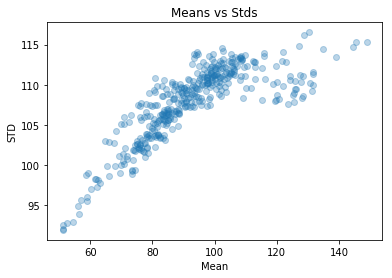

In [18]:
plt.scatter(mean_f,std_f,alpha=0.3)
plt.title("Means vs Stds")
plt.xlabel('Mean')
plt.ylabel('STD')
plt.show()

**COMMENT:** It can be seen clearly from the above figure that the mean is proportional with the std. When the mean increase, the std also rise as well. The distribution of the dots shape a curve or line like a function.

### 0.2. Standardize the features matrix DATA by centering and rescaling each random variable Xj into a new random variable Yj= (Xj - mj) /sj 

The matrix DATA becomes a standardized data matrix SDATA, with coefficients given by SDATA(i,j) = (DATA(i,j) - mj )/sj

In [19]:
sdata = (data - mean_f)/std_f
print('Display first 5 rows of SDATA \n',np.round(sdata[:5,:5],3))
end_time=tm.time()
print(' The computing time for the part 0 is ' , round (end_time-start_time,2), 'second')

Display first 5 rows of SDATA 
 [[-0.59  -0.658 -0.698 -0.743 -0.815]
 [-0.59  -0.583 -0.577 -0.613 -0.413]
 [-0.59  -0.64  -0.512 -0.324 -0.212]
 [-0.59  -0.658 -0.698 -0.743 -0.815]
 [ 1.977  1.74   1.667  1.62   1.504]]
 The computing time for the part 0 is  616.44 second


---
## PART 1
### 1.1 Compute the correlation matrix COR of the 400 random variables Y1,..., Y400

In [20]:
start_time=tm.time()
cor_mtx=np.corrcoef(data.T)
print('Display first 5 rows of correlation matrix COR of DATA \n',np.round(cor_mtx[:5,:5],5))

Display first 5 rows of correlation matrix COR of DATA 
 [[1.      0.92424 0.79024 0.62546 0.45097]
 [0.92424 1.      0.89406 0.70352 0.50868]
 [0.79024 0.89406 1.      0.86664 0.6432 ]
 [0.62546 0.70352 0.86664 1.      0.84092]
 [0.45097 0.50868 0.6432  0.84092 1.     ]]


### 1.2. For the matrix COR , compute its 400 eigenvalues λ1 > λ2 > ... > λ400 > 0 , and its 400 eigenvectors v1, v2, ..., v400

In [21]:
eig_val, eig_vec = LA.eig(cor_mtx)
print('Display first 5 eigen values \n',np.round(eig_val[:5],5))
print('Display first five eigen vectors \n',np.round(eig_vec[:5,:5],5))


Display first 5 eigen values 
 [49.84356 35.38121 18.88504 18.40569 17.58024]
Display first five eigen vectors 
 [[ 0.01826 -0.00925 -0.00363 -0.09989 -0.00793]
 [ 0.01324 -0.0111  -0.00464 -0.10357 -0.01645]
 [ 0.01605 -0.01334 -0.00087 -0.09573 -0.03043]
 [ 0.02208 -0.01475  0.0016  -0.07692 -0.04258]
 [ 0.02412 -0.01622 -0.00223 -0.05335 -0.04899]]


In [22]:
#find Ai
vm=eig_vec[:,:5]
Ai=np.matmul(sdata,vm)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(Ai)
print(kmeans.cluster_centers_)
kmeans.inertia_

[[ 0.88439227  6.48603252 -0.33624627 -0.31899124  1.42736734]
 [ 9.83009767 -3.63436809 -1.07065519  1.1013714  -0.6438941 ]
 [-4.21549807 -2.25700487  0.59350091 -0.23816676 -0.55569977]]


1285466.8366280713

### 1.3. Plot the decreasing curve λj versus j for j=1 , 2, ..., 400

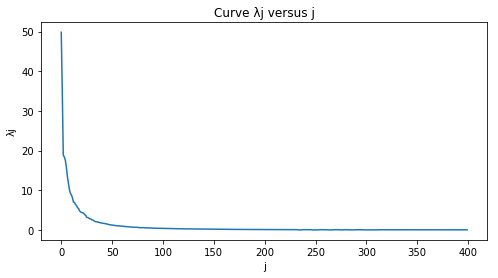

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.plot(np.arange(400),eig_val)
ax.set(title='Curve \u03BBj versus j', ylabel='\u03BBj', xlabel='j')
plt.show()

### 1.4. for j =1 ,2, ... ,400 compute the successive percentages Rj given by Rj = (λ1 + λ2 + ... + λj)/400



In [24]:
R=np.empty(400)
for i in np.arange(400):
  R[i]=sum(eig_val[:i+1])/400
print('Display first five values of Rj \n',np.round(R[:5],4))

Display first five values of Rj 
 [0.1246 0.2131 0.2603 0.3063 0.3502]


### 1.5. Plot the increasing curve Rj versus j for j=1 , 2, ..., 400 and compute the smallest integer "r" such that Rr >90%

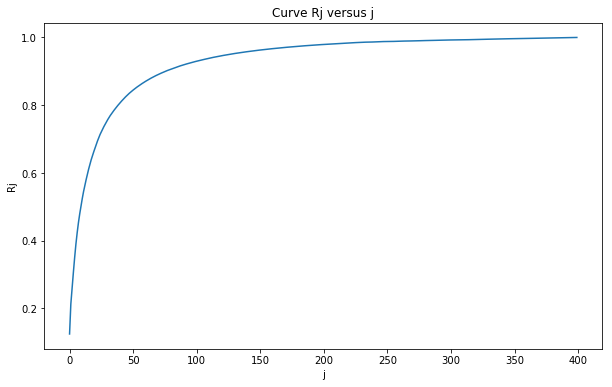

The smallest integer "r" such that Rr > 90% is 77


In [25]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(400),R)
ax.set(title='Curve Rj versus j', ylabel='Rj', xlabel='j')
plt.show()
for i in np.arange(400):
    if R[i]>0.90:
        min_r=i+1
        break
print('The smallest integer "r" such that Rr > 90% is',min_r)
  

### 1.6) Explain the relationship between these computations and the PCA analysis of the set DATA
In part 0, we computed means, standard deviations of 400 features and the histogram shows that those features have a wide range of values. So if we don't standardlize the data, the PCA analysis of the set DATA will not be effective.

SDATA=$\frac{DATA-MEAN}{Std}$

By using the above formula, we can center the data and standardize the data’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.

In part 1, we calculated the correlation matrix, eigen values and eigen vectors,\u03BBj and Rj. These computations help us to reduce the dimension of the set DATA with a certain level of confidence

First, by using the correlation matrix, we can get the 400 eigenvalues. Then the smallest *j* which satisfies the condition Rj > 90% was obtained. We got *j*$_{smallest}$ =77, which means that we can reduce the dimension of the set DATA to 77 features while we can still guarantee with 90% confident level that the result will be the same.

### 1.7) Implement the PCA analysis of the rescaled data matrix SDATA either in R or in Python, or in Matlab; explain clearly the inputs and the outputs of the pre-existing standard PCA functions you use

Example values of principal components array 
 [[-1.0370e+00  7.1650e+00 -5.5860e+00 -5.6400e-01  2.1840e+00]
 [ 1.2135e+01 -9.0360e+00  1.1520e+00  6.9000e-01  6.0000e-03]
 [ 9.8420e+00  4.4400e-01  8.3620e+00 -6.6770e+00 -3.3880e+00]
 [-9.7010e+00  1.3130e+00 -4.6680e+00  1.8420e+00 -4.3300e-01]
 [-3.0650e+00 -1.8350e+00 -1.5030e+00  1.2260e+00 -5.5670e+00]]

 First five explained variance ratios 
 [0.125 0.088 0.047 0.046 0.044] 



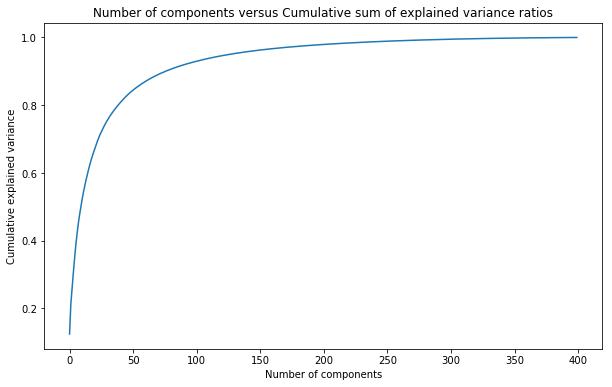

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Apply PCA analysis with number of features= 400 
pca = PCA(n_components=400)
principalComponents = pca.fit_transform(sdata)
print('Example values of principal components array \n', np.round(principalComponents[:5,:5],3))
print('\n First five explained variance ratios \n', np.round(pca.explained_variance_ratio_[:5],3),'\n')
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Number of components versus Cumulative sum of explained variance ratios')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

**Input and output of PCA functions**
- ***PCA(n_components)***: 
 - The **input** of PCA function within sklearn.decomposition pakage is the dimension you want to reduce to. For exampole, if you want to reduce your data to two dimensions so you can do the scatter plot to visualize it then you put n_components = 2 for input.
 - The **output** will be pca() we can use below.

- ***pca.fit_transform***: This function is a function chain rule denote by pca(fit_transform()). For fit_transform(), it can transfrom your origianal data to a lower or eual dimension by PCA analysis. 
 - The **input** will be the original (untouched) data. 
 - The **output** will be the rescale data transform by pca analysis with the dimension you want. In this homework, the output is the standardlized data set SDATA

- ***pca.explained_variance_ratio_***: this function is a function chain rule too,can be denoted as pca(explained_variance_ratio_()). 
 - This function requires no **input**
 - For the **output**, It will return the reliable confidence level persentage of each coordinate after pca transformation. Eventually, if the dimension is 400, it will return 400 number represent the reliable confidence level for the 400 coordinates.

### 1.8) The standardized example # i is described by row "i" of SDATA . 

After matrix transposition, this row becomes a column vector Ei in R400 . Compute the first three "scores" of example "i" by scor1 (i)= < Ei, v1> , scor2 (i)= < Ei, v2> , scor3 (i)= < Ei, v3>, These 3 numbers are the coordinates of a 3-dimensional vector Ui in R3. 

The 2 numbers scor1 (i), scor2 (i) define a 2-dimensional vector Wi in R3. Explain the geometric relationship between Ei, Ui,Wi.

In [27]:
def proj_sca(a,b): #vector projection of a on b
    magn_b=np.sum(b**2)
    #print(magn_b)
    a_b=np.sum(a*b)
    #print(a_b)
    proj_a=(a_b/magn_b)
    return proj_a
noc=sdata.shape[0] #Number of cases
scor1=np.empty(noc)
scor2=np.empty(noc)
scor3=np.empty(noc)
for i in np.arange(noc):
  scor1[i]=proj_sca(sdata[i,:],eig_vec[:,0])
  scor2[i]=proj_sca(sdata[i,:],eig_vec[:,1])
  scor3[i]=proj_sca(sdata[i,:],eig_vec[:,2])    

### 1.9) Display graphically the 2 dimensional scatterplot of all the Wi , i= 1,2,...,N , using 3 colors (1 for each class); 

for instance red for CL1, blue for CL2 ; green for CL3. Interpret this display visually in terms of separability of the 3 classes

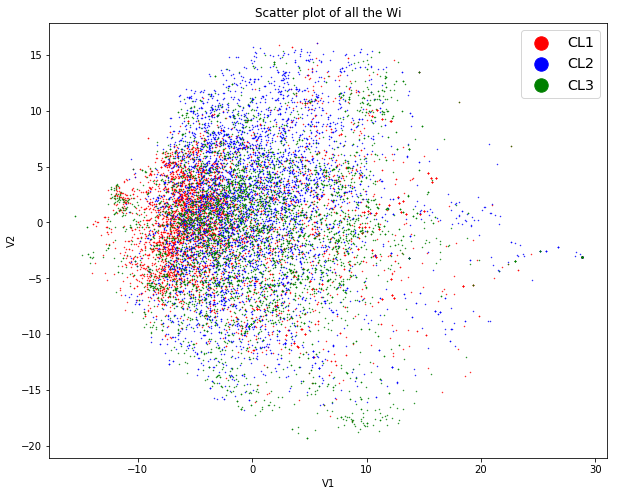

In [28]:
l_cl1=len(cl[0])
l_cl2=len(cl[0])+len(cl[1])
plt.figure(figsize=(10,8))
plt.scatter(scor1[:l_cl1],scor2[:l_cl1],color='red',s=0.2) 
plt.scatter(scor1[l_cl1:l_cl2],scor2[l_cl1:l_cl2],color='blue',s=0.2)
plt.scatter(scor1[l_cl2:],scor2[l_cl2:],color='green',s=0.2) 
plt.title('Scatter plot of all the Wi')
plt.legend(['CL1','CL2','CL3'],markerscale=30,fontsize='x-large')
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()

###1.10) Display graphically the 3 dimensional scatterplot of all the Ui , i= 1,2,...,N , with the same 3 colors;
Interpret visually. To facilitate the visual interpretation generate a similar display but with only the two
classes CL1 and CL2. Repeat this operation and visual interpretation for CL1 and CL3, and then for CL2
and CL3

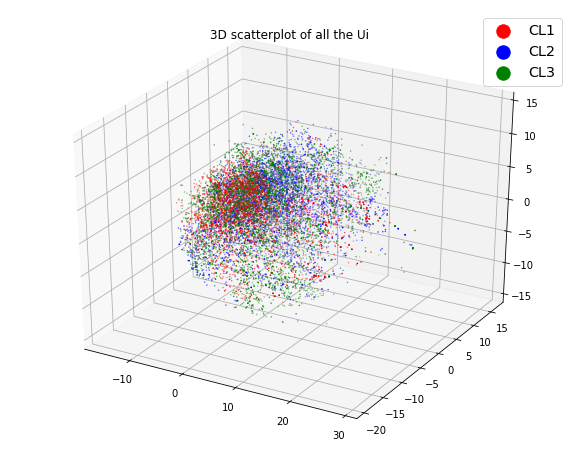

In [29]:
# Scatter plot of all Ui
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('3D scatterplot of all the Ui')
ax.scatter(scor1[:l_cl1],scor2[:l_cl1],scor3[:l_cl1],color='red',s=0.2) 
ax.scatter(scor1[l_cl1:l_cl2],scor2[l_cl1:l_cl2],scor3[l_cl1:l_cl2],color='blue',s=0.2)
ax.scatter(scor1[l_cl2:],scor2[l_cl2:],scor3[l_cl2:],color='green',s=0.2) 
plt.legend(['CL1','CL2','CL3'],markerscale=30,fontsize='x-large')
plt.show()

**INTERPRET:**
Eventhough it seems that CL1, CL2 and CL3 mix together, we still can reluctantly conclude some informations from this graph. First, we can tell that CL1 is much more concentrated than CL2 and CL3. Moreover, CL2 is slighty more concnetrated than CL3.

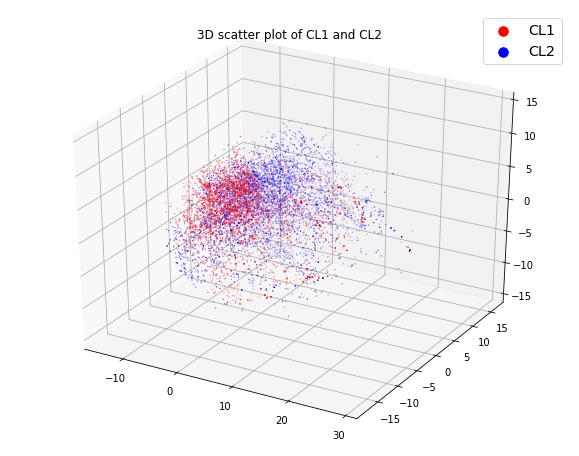

In [30]:
#Only CL1 and CL2
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scor1[:l_cl1],scor2[:l_cl1],scor3[:l_cl1],color='red',s=0.1) 
ax.scatter(scor1[l_cl1:l_cl2],scor2[l_cl1:l_cl2],scor3[l_cl1:l_cl2],color='blue',s=0.1)
#ax.scatter(scor1[l_cl2:],scor2[l_cl2:],scor3[l_cl2:],color='green',s=0.1) 
plt.title('3D scatter plot of CL1 and CL2')
plt.legend(['CL1','CL2'],markerscale=30,fontsize='x-large')
plt.show()


**INTERPRET:**
The red dots concentrate in a small area while blue dots spread well over the space.We can conclude more clearly by this graph than the graph above that CL1 is much more concentrated than CL2

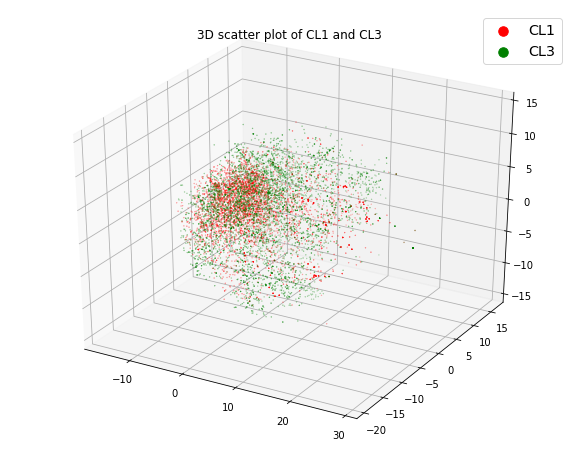

In [31]:
#Only CL1 and CL3
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scor1[:l_cl1],scor2[:l_cl1],scor3[:l_cl1],color='red',s=0.1) 
#ax.scatter(scor1[l_cl1:l_cl2],scor2[l_cl1:l_cl2],scor3[l_cl1:l_cl2],color='blue',s=0.1)
ax.scatter(scor1[l_cl2:],scor2[l_cl2:],scor3[l_cl2:],color='green',s=0.1) 
plt.title('3D scatter plot of CL1 and CL3')
plt.legend(['CL1','CL3'],markerscale=30,fontsize='x-large')
plt.show()

**INTERPRET:**
This plot also displays the same situation as the previous plot. The distribution of CL1 is in a small volume but the one of CL3 has a wide range. Therefore, it can be said that there is a significance discrimination between CL1 and CL3. 

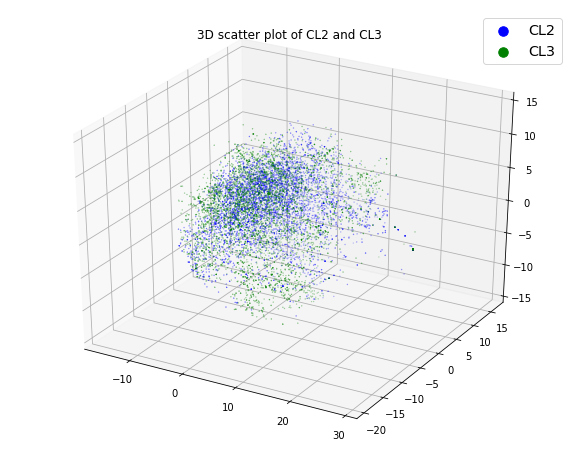

In [32]:
#Only CL2 and CL3
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(scor1[:l_cl1],scor2[:l_cl1],scor3[:l_cl1],color='red',s=0.1) 
ax.scatter(scor1[l_cl1:l_cl2],scor2[l_cl1:l_cl2],scor3[l_cl1:l_cl2],color='blue',s=0.1)
ax.scatter(scor1[l_cl2:],scor2[l_cl2:],scor3[l_cl2:],color='green',s=0.1)
plt.title('3D scatter plot of CL2 and CL3')
plt.legend(['CL2','CL3'],markerscale=30,fontsize='x-large')
plt.show()

**INTERPRET:**
In this plot, both the distributions of blue dots and green dots have a wide range. However it seems that the green dots spread a little bit wider than the blue dots. We can also conclude that there is a slight separation between CL2 and CL3.
In summary, we can finally conclude that CL1 is more concentrated than CL2 and CL2 is more concentrated than CL3

In [33]:
end_time=tm.time()
print(' The computing time for the part 1 is ' , round (end_time-start_time,2), 'second')

 The computing time for the part 1 is  21.04 second


---
## Part 2
### 2.1) Fix k = 15. Use the standardized data matrix SDATA to apply the k nearest neighbor (kNN) algorithm
for the automatic classification of arbitrary examples into one of the three classes CL1 CL2 CL3. Compute
the percentage per(15) of correct classifications on the whole data set of N examples


In [34]:
start_time=tm.time()
k=15
#To avoid over-fitting, we will divide our dataset into training and test splits
#We splits the dataset into train data and test data with different ratios
#Percentage of test set is from 0.2 to 0.35
classifier = KNeighborsClassifier(n_neighbors=k)
score=np.empty(4)
for i in np.arange(4):
  tes_siz=np.round(0.2+i*0.05,2)
  sdata_train, sdata_test,font_train,font_test= train_test_split(sdata,data_df.font, test_size=tes_siz)
  classifier.fit(sdata_train, font_train)
  font_pred = classifier.predict(sdata_test)
  print('\n If the percentage of test set is',tes_siz,' then the confusion matrix is \n',confusion_matrix(font_test, font_pred))
  score[i]=metrics.accuracy_score(font_test, font_pred)
  print('\n And the performance is',np.round(score[i],3))


 If the percentage of test set is 0.2  then the confusion matrix is 
 [[774  69 119]
 [102 575 137]
 [130  80 781]]

 And the performance is 0.77

 If the percentage of test set is 0.25  then the confusion matrix is 
 [[877 108 144]
 [142 727 189]
 [147 131 994]]

 And the performance is 0.751

 If the percentage of test set is 0.3  then the confusion matrix is 
 [[1161  104  181]
 [ 198  871  214]
 [ 180  146 1096]]

 And the performance is 0.754

 If the percentage of test set is 0.35  then the confusion matrix is 
 [[1330  120  222]
 [ 218 1014  260]
 [ 215  162 1302]]

 And the performance is 0.753


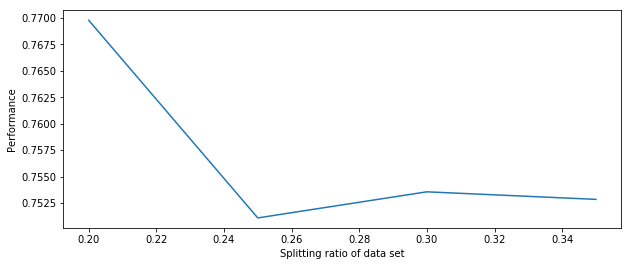

In [35]:
plt.close()
plt.figure(figsize=(10,4))
plt.xlabel('Splitting ratio of data set')
plt.ylabel('Performance')
plt.plot(np.arange(4)*0.05+0.2,score)
plt.title=('Performance versus splitting ratio')
plt.show()

$\rightarrow$ **Based on the graph, it seems that the 80:20 ratio is the best one to attain the highest performance**

### 2.2) Repeat the preceding operation for k = 5, 10 , 15, 20, 30, 40, 50 ,100,200; and compute the percentages per(k) of correct classifications on the whole data set of N examples
plot the curve per(k) versus k to try to identify a best range [A < k <B] of values for the integer k


In [36]:
k_vals=[5, 10 , 15, 20, 30, 40, 50 ,100,200]
per=np.empty(len(k_vals))
for i in np.arange(len(k_vals)):
  classifier = KNeighborsClassifier(n_neighbors=k_vals[i])
  sdata_train, sdata_test,font_train,font_test= train_test_split(sdata,data_df.font, test_size=0.2)
  classifier.fit(sdata_train, font_train)
  font_pred = classifier.predict(sdata_test)
  #print(confusion_matrix(font_test, font_pred))
  per[i]=metrics.accuracy_score(font_test, font_pred)

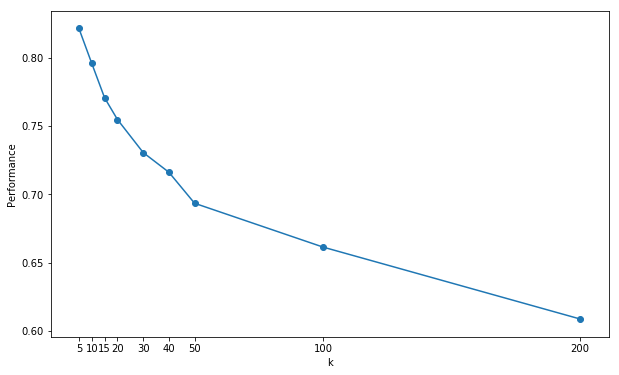

Percentages of correct classifications for each k is 
 [0.8218287  0.79616914 0.77087098 0.75496928 0.73075533 0.71629924
 0.6935309  0.6613661  0.60860137]


In [37]:
plt.figure(figsize=(10,6))
plt.plot(k_vals,per)
plt.scatter(k_vals,per)
plt.xticks(k_vals)
plt.title=('Performance versus k values')
plt.xlabel('k')
plt.ylabel('Performance')
plt.show()
print('Percentages of correct classifications for each k is \n', per)

### 2.3) Repeat the preceding exploration for a few more values of k within the range [A,B]. Conclude by selecting a "best" value k* for the integer k


In [38]:
k_vals_1=[5, 8, 11, 14, 17, 20, 23]
per1=np.empty(len(k_vals_1))
for i in np.arange(len(k_vals_1)):
  classifier = KNeighborsClassifier(n_neighbors=k_vals_1[i])
  sdata_train, sdata_test,font_train,font_test= train_test_split(sdata,data_df.font, test_size=0.2)
  classifier.fit(sdata_train, font_train)
  font_pred = classifier.predict(sdata_test)
  #print(confusion_matrix(font_test, font_pred))
  per1[i]=metrics.accuracy_score(font_test, font_pred)

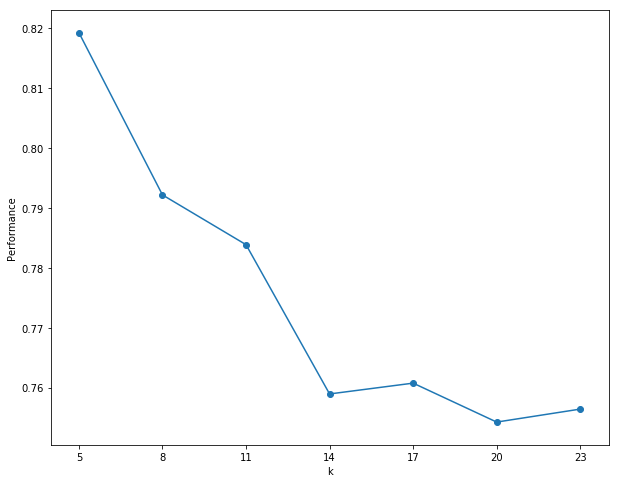

[0.81929888 0.79219371 0.78388146 0.75894471 0.76075172 0.75424648
 0.75641489]


In [39]:
plt.figure(figsize=(10,8))
plt.plot(k_vals_1,per1)
plt.scatter(k_vals_1,per1)
plt.xticks(k_vals_1)
plt.title=('Performance versus k values')
plt.xlabel('k')
plt.ylabel('Performance')
plt.show()
print(per1)

**We can conclude by the elbow theorem that k* = 8**

### 2.4) Compute and interpret the 3x3 confusion matrix for kNN classification using the "best" k= k*

In [40]:
classifier = KNeighborsClassifier(n_neighbors=1)
sdata_train, sdata_test,font_train,font_test= train_test_split(sdata,data_df.font, test_size=0.2)
classifier.fit(sdata_train, font_train)
font_pred = classifier.predict(sdata_test)
print('Confusion matrix for k = 8 is \n',confusion_matrix(font_test, font_pred))

Confusion matrix for k = 8 is 
 [[817  38  74]
 [ 61 702  98]
 [ 53  93 831]]


A confusion matrix is often used to describe the performance of a lassification model (or “classifier”) on a set of test data for which the true values are known. 

NA |Predicted CL1 |Predicted CL2 | Predicted CL3
--|--|--|--
True CL1|855|34|87|
True CL2|121|633|97|
True CL3|114|95|731| 

In [41]:
end_time=tm.time()
print(' The computing time for the part 2 is ' , round (end_time-start_time,2), 'second')

 The computing time for the part 2 is  625.57 second
